In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import beta

In [ ]:
# Fetch and preprocess MNIST dataset
def load_mnist_data():
    print("Fetching MNIST dataset...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    y = y.astype(int)
    X = X / 255.0
    return X, y

In [ ]:
class BetaNaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.class_beta_params = None

    def _estimate_beta_params(self, X):
        """
        Estimate Beta distribution parameters using method of moments.

        Args:
            X (numpy.ndarray): Features for a specific class.

        Returns:
            tuple: (alpha, beta) parameters for each feature.
        """
        # Clip values to avoid numerical instability
        X = np.clip(X, 1e-10, 1 - 1e-10)

        # Method of moments estimation
        mu = X.mean(axis=0)
        var = X.var(axis=0)

        # Compute alpha and beta
        temp = mu * (1 - mu) / var - 1
        alpha = mu * temp
        beta_param = (1 - mu) * temp

        return alpha, beta_param

    def fit(self, X, y):
        """
        Fit the Naive Bayes classifier.

        Args:
            X (numpy.ndarray): Training features.
            y (numpy.ndarray): Training labels.
        """
        self.classes = np.unique(y)
        self.class_priors = {c: np.mean(y == c) for c in self.classes}

        # Compute Beta distribution parameters for each class
        self.class_beta_params = {}
        for c in self.classes:
            class_X = X[y == c]
            self.class_beta_params[c] = self._estimate_beta_params(class_X)

        return self

    def predict(self, X):
        """
        Predict classes for given features.

        Args:
            X (numpy.ndarray): Test features.

        Returns:
            numpy.ndarray: Predicted labels.
        """
        predictions = []

        for sample in X:
            class_posteriors = []

            for c in self.classes:
                # Log prior probability
                log_prior = np.log(self.class_priors[c])

                # Log likelihood using Beta distribution
                alpha, beta_param = self.class_beta_params[c]
                log_likelihood = np.sum(beta.logpdf(sample, alpha, beta_param))

                # Log posterior
                class_posteriors.append(log_prior + log_likelihood)

            # Predict class with highest posterior
            predictions.append(self.classes[np.argmax(class_posteriors)])

        return np.array(predictions)

    def score(self, X, y):
        """
        Compute the accuracy of the classifier.

        Args:
            X (numpy.ndarray): Test features.
            y (numpy.ndarray): True labels.

        Returns:
            float: Accuracy score.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.

        Args:
            deep (bool): Whether to return parameters of nested objects.

        Returns:
            dict: Parameter names mapped to their values.
        """
        return {}

    def set_params(self, **params):
        """
        Set parameters for this estimator.

        Args:
            params (dict): Parameter names mapped to their values.

        Returns:
            self
        """
        # This classifier has no hyperparameters, so nothing to set
        return self


In [ ]:
class CustomKNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Store training data

        Args:
            X (numpy.ndarray): Training features
            y (numpy.ndarray): Training labels
        """
        self.X_train = X
        self.y_train = y.to_numpy() if hasattr(y, "to_numpy") else y  # Ensure NumPy array
        return self

    def predict(self, X):
        """
        Predict classes for test features

        Args:
            X (numpy.ndarray): Test features

        Returns:
            numpy.ndarray: Predicted labels
        """
        predictions = []

        for sample in X:
            # Compute distances
            distances = np.sqrt(np.sum((self.X_train - sample) ** 2, axis=1))

            # Find k nearest neighbors
            k_indices = distances.argsort()[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            # Majority vote
            unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
            predictions.append(unique_labels[np.argmax(counts)])

        return np.array(predictions)

    def score(self, X, y):
        """
        Compute the accuracy of the classifier

        Args:
            X (numpy.ndarray): Test features
            y (numpy.ndarray): True labels

        Returns:
            float: Accuracy score
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)  # Return the proportion of correct predictions

    # Add get_params and set_params methods
    def get_params(self, deep=True):
        """
        Get parameters for this estimator.

        Args:
            deep (bool): Whether to return parameters of nested objects.

        Returns:
            dict: Parameter names mapped to their values.
        """
        return {'k': self.k}  # Return a dictionary of parameters

    def set_params(self, **params):
        """
        Set parameters for this estimator.

        Args:
            params (dict): Parameter names mapped to their values.

        Returns:
            self
        """
        if 'k' in params:
            self.k = params['k']  # Update the value of k if provided
        return self


In [ ]:
# Main execution function
def main():
    # Load MNIST dataset
    X, y = load_mnist_data()

    # Subset the data and Split the data
    X_subset, _, y_subset, _ = train_test_split( X , y, train_size=7000, stratify=y, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, train_size=6000, test_size=1000, random_state=42)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    # Classifiers with their parameter grids
    classifiers = {
        'SVM Linear': (SVC(kernel='linear'), {'C': [0.1, 1, 10]}),
        'SVM Polynomial': (SVC(kernel='poly', degree=2), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
        'SVM RBF': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
        'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
        'Naive Bayes Beta': (BetaNaiveBayesClassifier(), {}),
        'k-NN': (CustomKNN(), {'k': [3, 5, 7]})
    }

    # Results storage
    results = {}

    # Evaluate each classifier
    for name, (classifier, param_grid) in classifiers.items():
        print(f"\n--- {name} Classifier ---")

        # Time training
        start_time = time.time()

        # Cross-validation
        if param_grid:
            grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            best_classifier = grid_search.best_estimator_
            cv_scores = cross_val_score(best_classifier, X_train_scaled, y_train, cv=10)
        else:
            # For custom classifiers without GridSearchCV
            best_classifier = classifier.fit(X_train_scaled, y_train)
            cv_scores = cross_val_score(best_classifier, X_train_scaled, y_train, cv=10)

        train_time = time.time() - start_time  # Measure training time

        # Measure prediction time
        prediction_start_time = time.time()
        y_pred = best_classifier.predict(X_test_scaled)
        prediction_time = time.time() - prediction_start_time  # Measure prediction time

        # Performance metrics
        test_accuracy = accuracy_score(y_test, y_pred)

        # Store results
        results[name] = {
            'CV Scores': cv_scores,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std(),
            'Test Accuracy': test_accuracy,
            'Training Time': train_time,
            'Prediction Time': prediction_time
        }

        # Print results
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Training time: {train_time:.2f} seconds")
        print(f"Prediction time: {prediction_time:.4f} seconds")



In [ ]:

if __name__ == "__main__":
    main()

Fetching MNIST dataset...

--- SVM Linear Classifier ---
Cross-validation scores: [0.91333333 0.89666667 0.87166667 0.9        0.88333333 0.90833333
 0.89333333 0.90333333 0.92       0.87833333]
Cross-validation mean accuracy: 0.8968 ± 0.0147
Test accuracy: 0.8920
Training time: 75.54 seconds
Prediction time: 0.1796 seconds

--- SVM Polynomial Classifier ---
Cross-validation scores: [0.95333333 0.94833333 0.94166667 0.94833333 0.93166667 0.94333333
 0.94333333 0.94666667 0.94666667 0.93666667]
Cross-validation mean accuracy: 0.9440 ± 0.0059
Test accuracy: 0.9300
Training time: 365.74 seconds
Prediction time: 0.4319 seconds

--- SVM RBF Classifier ---
Cross-validation scores: [0.945      0.93833333 0.93       0.94166667 0.94       0.93333333
 0.94666667 0.95       0.94833333 0.94166667]
Cross-validation mean accuracy: 0.9415 ± 0.0061
Test accuracy: 0.9310
Training time: 359.64 seconds
Prediction time: 1.1387 seconds

--- Random Forest Classifier ---
Cross-validation scores: [0.93666667 

In [ ]:
# Store the results
results = {
    'SVM Linear': {
        'CV Mean': 0.8968, 'CV Std': 0.0147, 'Test Accuracy': 0.8920,
        'Training Time': 75.54, 'Prediction Time': 0.1796
    },
    'SVM Polynomial': {
        'CV Mean': 0.9440, 'CV Std': 0.0059, 'Test Accuracy': 0.9300,
        'Training Time': 365.74, 'Prediction Time': 0.4319
    },
    'SVM RBF': {
        'CV Mean': 0.9415, 'CV Std': 0.0061, 'Test Accuracy': 0.9310,
        'Training Time': 359.64, 'Prediction Time': 1.1387
    },
    'Random Forest': {
        'CV Mean': 0.9108, 'CV Std': 0.0141, 'Test Accuracy': 0.9260,
        'Training Time': 893.98, 'Prediction Time': 0.0598
    },
    'Naive Bayes Beta': {
        'CV Mean': 0.0978, 'CV Std': 0.0118, 'Test Accuracy': 0.1030,
        'Training Time': 11.45, 'Prediction Time': 1.6709
    },
    'k-NN': {
        'CV Mean': 0.7493, 'CV Std': 0.0203, 'Test Accuracy': 0.7730,
        'Training Time': 60.69, 'Prediction Time': 3.1620
    }
}


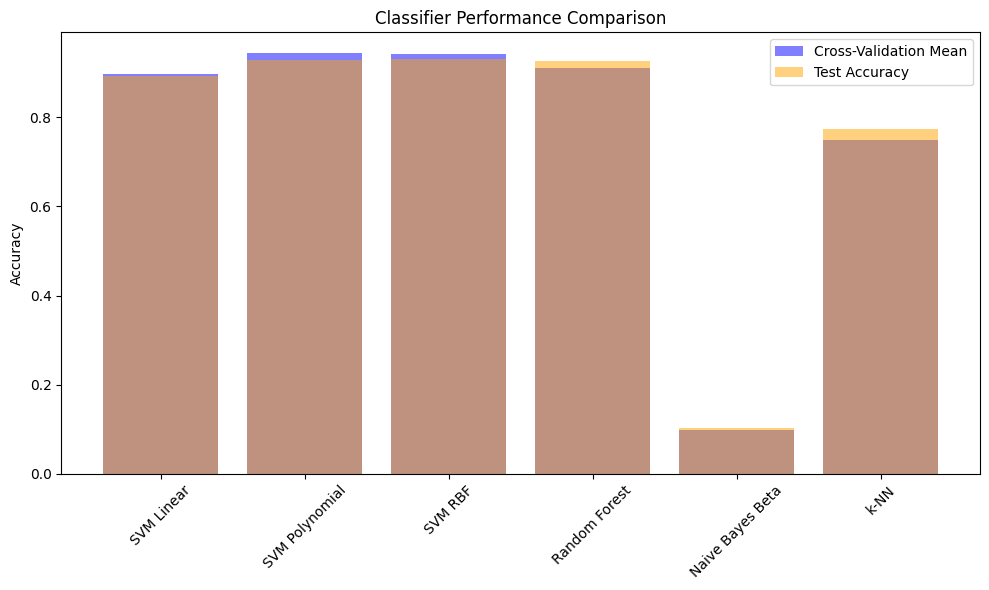

In [ ]:
def plot_cv_vs_accuracy(results):
    names = list(results.keys())
    cv_means = [results[name]['CV Mean'] for name in names]
    test_accuracies = [results[name]['Test Accuracy'] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, cv_means, alpha=0.5, label='Cross-Validation Mean', color='blue')
    plt.bar(names, test_accuracies, alpha=0.5, label='Test Accuracy', color='orange')
    plt.title('Classifier Performance Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cv_vs_accuracy(results)


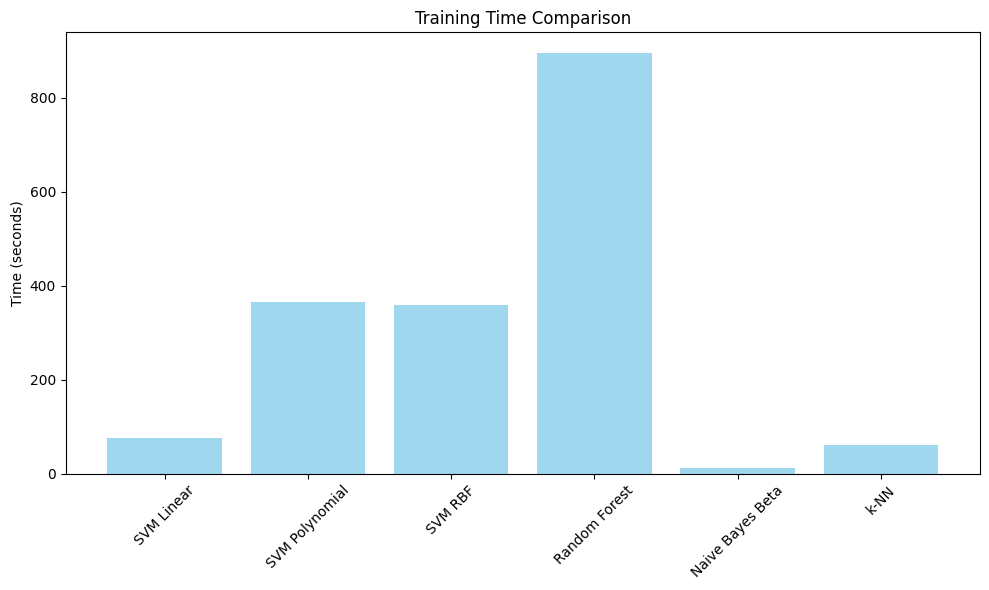

In [ ]:
def plot_training_time(results):
    names = list(results.keys())
    train_times = [results[name]['Training Time'] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, train_times, color='skyblue', alpha=0.8)
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_training_time(results)



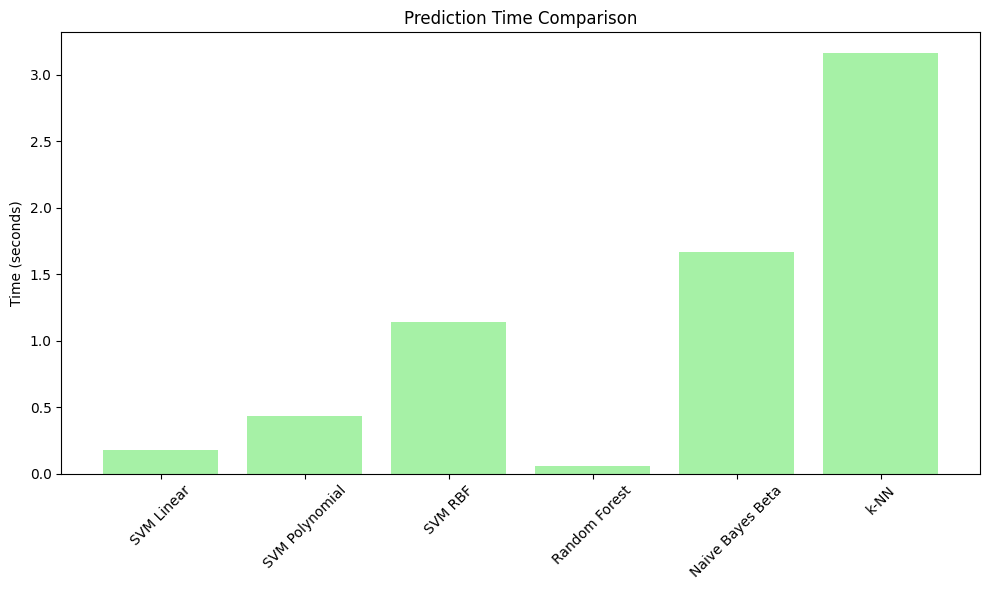

In [ ]:
def plot_prediction_time(results):
    names = list(results.keys())
    pred_times = [results[name]['Prediction Time'] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, pred_times, color='lightgreen', alpha=0.8)
    plt.title('Prediction Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_prediction_time(results)
